# TIF345 Advanced Simulation and Machine Learning
## Lab1
Andreas Ekström, 2020

The goal of this computer lab is to:
1. numerically verify some marginalized posteriors in Bayesian regression 
2. construct your own Gaussian process (GP) from scratch
3. test/apply your own GP to a simple 1d linear regression problem

# Import relevant modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma, t, norm
# for plotting 
import seaborn as sns
sns.set_context("paper", font_scale=1.5)
sns.set_style("darkgrid")
sns.set_palette("deep")
sns.set(font='sans-serif')
%matplotlib inline
plt.rcParams['figure.dpi'] = 140

# Marginalizing posteriors

In [2]:
#define a few necessary distributions
#perhaps helpful 
def normal_distribution(mu,sigma2):
    return norm(loc=mu,scale=np.sqrt(sigma2))

def ig_distribution(alpha,beta):
    return invgamma(a=alpha,scale=beta)

def t_distribution(nu,mu,sigma_hat2):
    return t(df=nu,loc=mu,scale=np.sqrt(sigma_hat2))

def nig_pdf(th,s2,mu0,Sigma0,alpha,beta):

    if alpha<=0:
        print('error alpha<=0')
        return 0
    if beta<=0:
        print('error beta<=0')
        return 0
    
    NIG = norm.pdf(th,loc=mu0,scale=np.sqrt(s2)*np.sqrt(Sigma0))*invgamma.pdf(s2,a=alpha,scale=beta) 
    return NIG  

>## <font color='red'>Exercise: </font>
plot the pdf:s for a zero-mean normal- and T-distributions with $\sigma^2=2$. What happens when you increase the number of degrees of freedom for the T-distribution?

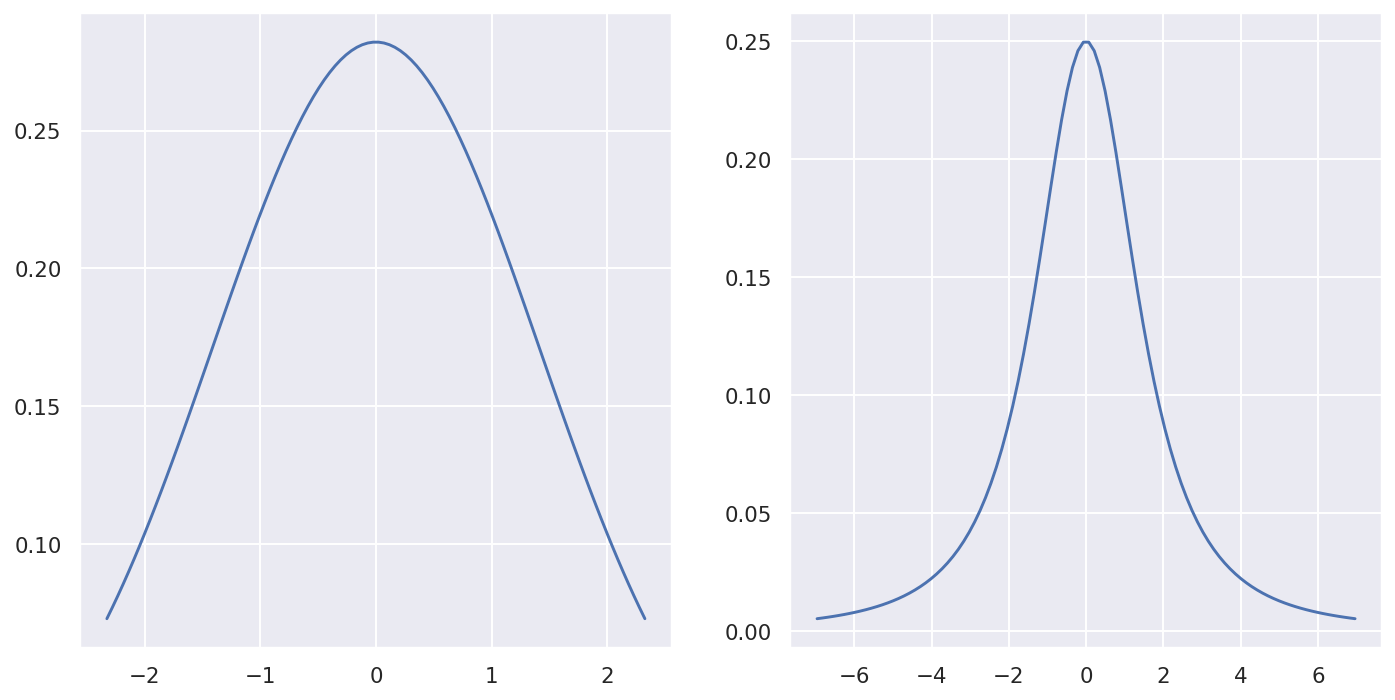

In [16]:
# your code goes here
fig, axs = plt.subplots(1,2, figsize=(12,6))
# Norm
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
axs[0].plot(x, normal_distribution(0, 2).pdf(x))
# T
df = 2
x = np.linspace(t.ppf(0.01, df),
                t.ppf(0.99, df), 100)
axs[1].plot(x, t_distribution(df, 0, 2).pdf(x))

### The normal-inverse gamma (NIG) prior

A NIG prior is conjugate to a likelihood with unknown $\boldsymbol \theta$ and $\sigma^2$, and is defined as

\begin{equation}
p(\boldsymbol\theta,\sigma^2) = p(\boldsymbol\theta|\sigma^2)p(\sigma^2) = \mathcal{N}(\boldsymbol \theta| \mathbf{\mu}_0,\sigma^2 \boldsymbol \Sigma)\cdot\mathcal{IG}(\sigma^2|\alpha,\beta) \equiv \mathcal{NIG}(\boldsymbol \theta, \sigma^2 |\boldsymbol \mu,\boldsymbol \Sigma,\alpha,\beta).
\end{equation}



### One can show that marginal distributions are given by
\begin{align}
  \begin{split}
    p(\boldsymbol{\theta}) {}& =\int \mathcal{NIG}(\boldsymbol{\theta},\sigma^2|\boldsymbol{\mu},\boldsymbol{\Sigma},\alpha,\beta)\,d\sigma^2 = \mathcal{T}_{2\alpha}(\boldsymbol{\theta}|\boldsymbol{\mu},(\beta/\alpha)\boldsymbol{\Sigma})\\
    p(\sigma^2) {}& = \int \mathcal{NIG}(\boldsymbol{\theta},\sigma^2|\boldsymbol{\mu},\boldsymbol{\Sigma},\alpha,\beta)\,d\boldsymbol{\theta} = \mathcal{IG}(\sigma^2|\alpha,\beta).
  \end{split}
\end{align}

>## <font color='red'>Exercise: </font>
Limit yourself to the 1-dimensional case (i.e. all vector and matrix input reduces to scalar input), and verify the above marginals by plotting the ($\theta$-) $\sigma^2$-integrated NIG pdf on top of the scipy-generated pdf for the (normal-) t-distribution.

0.952528281238962
0.9525282812389619


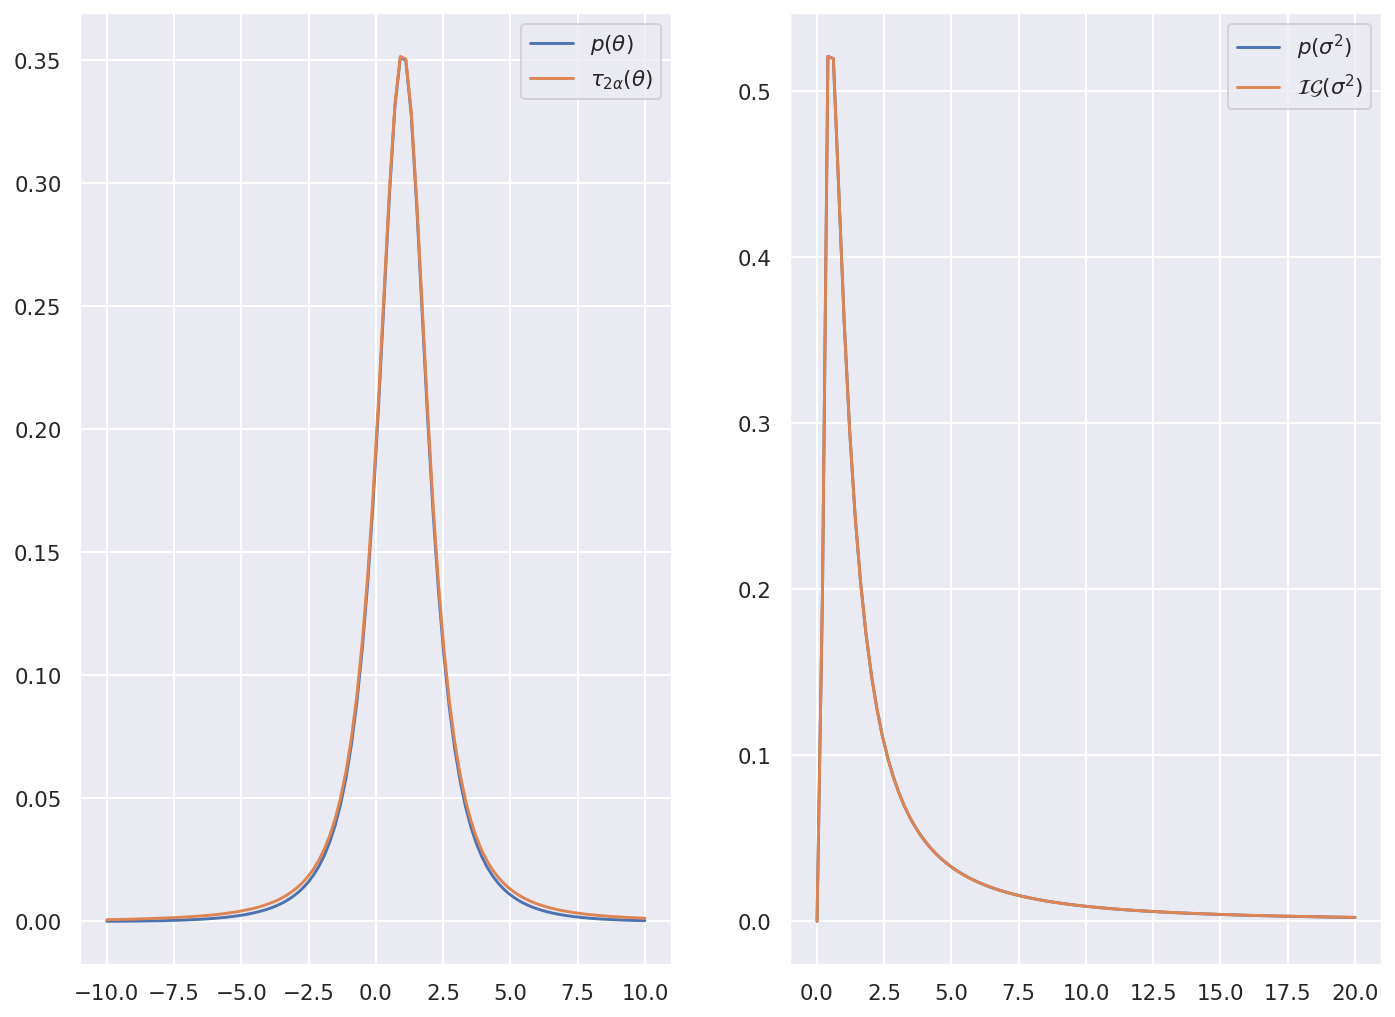

In [56]:
# your code goes here
theta = np.linspace(-10, 10, 100)
s2 = np.linspace(0.01, 20, 100)
mu0 = 1
Sigma0 = 1
alpha = 1
beta = 1
NIG = np.zeros((len(theta), len(s2)))
for i, th in enumerate(theta):
    for j, s in enumerate(s2):
        NIG[i, j] = nig_pdf(th, s, mu0, Sigma0, alpha, beta) 
p_s2 = np.trapz(y=NIG, x=theta, axis=0)
p_theta = np.trapz(y=NIG, x=s2, axis=1)
print(np.trapz(y=p_s2, x=s2))
print(np.trapz(y=p_theta, x=theta))

# Plot marginal distributions
fig, axs = plt.subplots(1,2, figsize=(12,9))
axs[0].plot(theta, p_theta, label=r'$p(\theta)$')
axs[0].plot(theta, t(2*alpha, mu0, beta/alpha*Sigma0).pdf(theta), label=r'$\tau_{2\alpha}(\theta)$')
axs[1].plot(s2, p_s2, label=r'$p(\sigma^2)$')
axs[1].plot(s2, ig_distribution(alpha, beta).pdf(s2), label=r'$\mathcal{IG}(\sigma^2)$')
axs[0].legend(loc='best')
axs[1].legend(loc='best')

>## <font color='red'>Exercise: </font>
What is the reason for the fatter tails of the t-distribution compared to the normal distribution? How can you intuitively explain why it reduces to the normal distribution for $\nu \rightarrow \infty$ ?

T-distribution is something we use when we don't know the standard deviation $\sigma^2$. The $\nu$ is how "certain" we are on the standard deviation $\sigma^2$. 
We can motivate that we should obtain a normal distribution (i.e. an explicit $\sigma^2$) from the equation for $p(\theta)$ which is a t-distribution: if we see $IG$ as a 
prior on $\sigma^2$, in the limit $\alpha \rightarrow \infty$ this will be infinitely peaked (a delta function). Thus we will pick out the normal distribution at a specific $\sigma^2$, which 
thus says that is the limit for the t-distribution. I.e. we are sure about the standard deviation, and we should get a normal distribution.

Following this logic, we should get fatter tailes for the t-distribution than the normal distribution, since we have an uncertainty in the standard deviation ("width"), and thus we would expect the plot 
to cover more values.


# Gaussian process regression

Below you will implement your own code for a 'vanilla' Gaussian process that you also condition on some data, i.e. specific points $(x_i,y_i)$. There exists highly optimized packages for using GP, but it is instructive to have implemented a GP from scratch at least once your life :)

You should use a squared exponential kernel with correlation length $\ell_{GP}=1$, variance $\sigma_{GP}^2=1$. Ignore the stage of optimizing hyperparameters. (feel free to do it if you'd like...).The review by Rasmussen and Williams is an excellent online resource for GP theory (http://www.gaussianprocess.org/gpml/chapters/RW.pdf) 

In a second step you should add incorporate some data noise (with variance $\sigma^2=0.1$) to the GP kernel. This way you can reproduce the GP 'waists' around the data points in the figure below. Indeed, if you look closely at the GP, you will notice that the GP variance does not shrink to zero in the vicinity of the (red) noise-free data points.

![alt text](GP_out.png "Conditioned GP")

In [173]:
#define some data from a cosine function (used above)
np.random.seed(1) # use this seed to get the same data as in the image above
Nd = 3

xd = np.random.uniform(-3.,3.,(Nd,1))
yd = np.cos(xd)
yd_error = yd + np.random.normal(0, np.sqrt(0.1), 3).reshape(-1,1)

###### generate the true function ######
xt = np.linspace(-5.,5.,100).reshape(-1,1)
yt = np.cos(xt)



In [174]:
# pretty-print matrices as a helper. If you need to print and debug small matrices...
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("") 

In [175]:
def kernel(X1, X2, l_gp, s_gp):
     return s_gp * np.exp( -0.5 / l_gp**2 * np.abs(X1-X2.T)**2)

# GP posterior: i.e. GP prior confronted with data {x_data,y_data}
def gp_posterior(x_pred, x_data, y_data, l_gp=1.0, s_gp = 1.0):
    sigma_xx = kernel(x_pred, x_pred, l_gp, s_gp)
    sigma_xd = kernel(x_pred, x_data, l_gp, s_gp)
    sigma_dx = kernel(x_data, x_pred, l_gp, s_gp)
    sigma_dd = kernel(x_data, x_data, l_gp, s_gp)
    print(sigma_xx.shape)
    print(sigma_xd.shape)
    print(sigma_dx.shape)
    print(sigma_dd.shape)
    mu = (sigma_xd@np.linalg.inv(sigma_dd))@y_data
    cov = sigma_xx - sigma_xd@np.linalg.inv(sigma_dd)@sigma_dx
    return mu.reshape(-1,1), cov

(100, 100)
(100, 3)
(3, 100)
(3, 3)


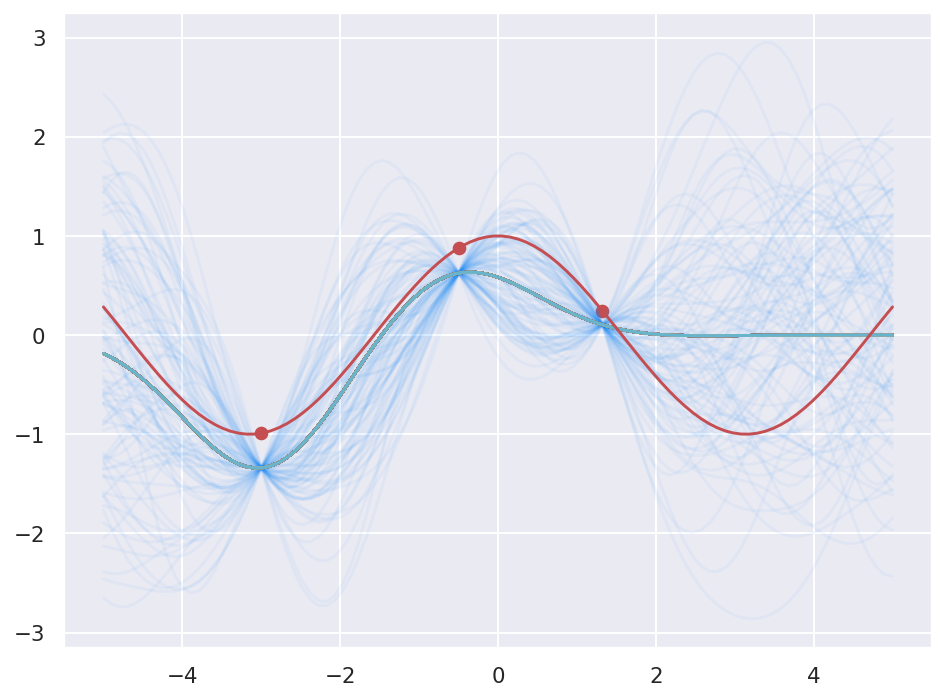

In [176]:
# Now, draw some samples from the GP posterior
X = np.linspace(-5, 5, 100).reshape(-1,1)


mu, cov = gp_posterior(X, xd, yd_error, 1, 1) # Add noise
samples = np.random.multivariate_normal(mu.ravel(), cov, 100)

fig, ax = plt.subplots(figsize=(8,6))
for sample in samples:
    ax.plot(X, sample, color='dodgerblue', alpha=0.05)
    ax.plot(X, mu, label=r'$\mu(x)$')
    # Plot 1 sigma band
#     ax.fill_between(X.ravel(), mu.ravel()-np.sqrt(np.diag(cov)).ravel(), mu.ravel()+np.sqrt(np.diag(cov)).ravel(), alpha=0.005, color='k' )
ax.plot(xt, yt, c='r')
ax.scatter(xd, yd, c='r')
plt.show()
# And plot the results

>## <font color='red'>Exercise: </font>
Why does the GP revert to the mean after a few correlation lengths?

# Optional: compare with GPy to test your result

In [ ]:
import GPy
from IPython.display import display
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(xd,yd,kernel)
m.Gaussian_noise.variance = 0.01
display(m)

In [ ]:
fig = m.plot()

In [84]:
X1 = np.array([0,1,2])
X2 = np.array([1,2,3])
print(np.outer(np.abs(X1-X2), np.abs(X1-X2)) )
print(np.abs(X1-X2.T)**2)

[[1 1 1]
 [1 1 1]
 [1 1 1]]
[1 1 1]
